## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import ElasticNet, Ridge, Lasso, Lars, LassoLars
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


# another way of ignoring warnings
warnings.filterwarnings('ignore')

#### Loading dataset

In [3]:
df_ = pd.read_csv("df_1hot.csv")
X = df_.iloc[:, 1:]
y = df_.iloc[:, 0]

#### Dealing with NaN values
##### Instead of filling NaN values with mean of the predictor, use KNN Imputer (Scikit-Learn).

This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found in the training set. By default, it uses a Euclidean distance metric to impute the missing values.

Another critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to **normalize** our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

We are setting the parameter ‘n_neighbors’ as 5. So, the missing values will be replaced by the mean value of 5 nearest neighbors measured by Euclidean distance.

```python
scaler = MinMaxScaler()
df_ = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

imputer = KNNImputer(n_neighbors=5)
df_ = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
df.head(10)
```

In [4]:
def fill_NaNs_KNN(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    ### 1. Fill NaN vlaues in continuous columns (X_cont)
    scaler = StandardScaler()
    scaled_X_cont = scaler.fit_transform(X_cont)
    knn_imputer = KNNImputer(n_neighbors=5)
    X_cont_imputed = knn_imputer.fit_transform(scaled_X_cont)
    X_cont_imputed = pd.DataFrame(X_cont_imputed, columns=X_cont.columns)

    ### 2. Fill NaN vlaues for the categorical columns (X_cat)
    #cat_imputer = SimpleImputer(strategy="most_frequent")
    #X_cat_imputed = cat_imputer.fit_transform(X_cat)
    #X_cat_imputed = pd.DataFrame(X_cat_imputed, columns=X_cat.columns)

    ### 4. 1-HOT-encoding of categorical columns
    #X_cat_imputed_1HOT = pd.get_dummies(X_cat_imputed, columns=X_cat_imputed.columns, drop_first=False).astype(int)
    
    ### 5. Merging y, X_con_imputed (standartized and NaN filled) and X_con_imputed_1HOT (NaN filled and relabelled, 1hotencoded)
    df_trans = pd.concat([X_cont_imputed.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

    return df_trans, df_trans.shape, scaler

def centerData_y(y):
    
    y_mu = np.mean(y,axis=0)
    y_centr = y - y_mu
    
    return y_centr, y_mu

def cont_cat(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    return X_cont, X_cat

def align_columns(Xtrain, Xtest):
    # Find columns in Xtrain and Xtest
    missing_in_Xtrain = set(Xtest.columns) - set(Xtrain.columns)
    missing_in_Xtest = set(Xtrain.columns) - set(Xtest.columns)
    
    # Add missing columns to the respective DataFrames
    for col in missing_in_Xtrain:
        Xtrain[col] = np.nan  # or you can use 0 if preferred
    
    for col in missing_in_Xtest:
        Xtest[col] = np.nan  # or you can use 0 if preferred

    # Ensure columns are in the same order
    Xtrain = Xtrain[Xtest.columns]

    return Xtrain, Xtest

def custom_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

### Ridge Regression

Best parameters for Ridge:  {'alpha': 2.9748743718592965}
Best cross-validation score: 0.6070
R² Score on the test dataset: 0.7465
MSE on the test dataset: 1654.5355
RMSE on the test dataset: 40.6760


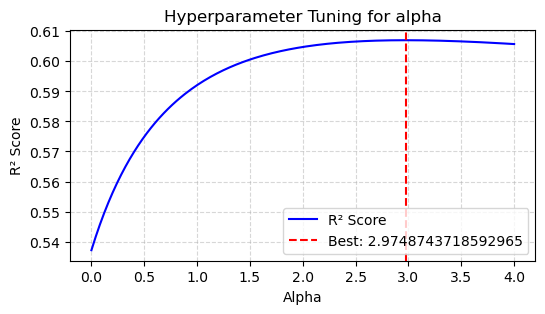

Best estimator: Ridge(alpha=2.9748743718592965)


In [5]:
# Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Ridge regression model
ridge = Ridge()

# Define the hyperparameter grid for alpha
param_grid_ridge = {
    'alpha' : np.linspace(0, 4, 200)
}

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = LeaveOneOut()

# Use GridSearchCV with the KFold object
Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
Ridge_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", Ridge_.best_params_)
print("Best cross-validation score: {:.4f}".format(Ridge_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = Ridge_.best_estimator_
y_pred_ridge = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_ridge)
test_MSE = mean_squared_error(ytest, y_pred_ridge)
test_RMSE = root_mean_squared_error(ytest, y_pred_ridge)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
alphas = np.linspace(0, 4, 200)
mean_test_scores = Ridge_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(Ridge_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Ridge_.best_params_['alpha']}")
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Ridge_.best_estimator_}')

In [6]:
# Get the mean test R² scores and standard deviations
meanError = list(Ridge_.cv_results_['mean_test_score'])
stdError = Ridge_.cv_results_['std_test_score']

# Find the index of the model with the highest mean R² score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the model with the highest alpha (if there are multiple models that satisfy the condition)
if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Ridge_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 4.0
One standard error rule gives the best model with mean_test_score (R²): 0.6057549269015239 and std_test_score: 0.42832480926405125


In [7]:
alpha = Ridge_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
ridge = Ridge(alpha=alpha)
ridge.fit(Xtrain, ytrain)
y_pred_ridge = ridge.predict(Xtest)
r2_ridge = r2_score(ytest, y_pred_ridge)
print(f'R² score for Ridge: {r2_ridge:.4f}')

R² score for Ridge: 0.7504


In [8]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_ridge,
    'Squared Error (SE)': (ytest - y_pred_ridge) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_ridge)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly


Mean Squared Error (MSE): 1628.69
Root Mean Squared Error (RMSE): 40.36
Standard Deviation of Actual Values: 82.88


### Lasso Regression

Best parameters for Lasso found:  {'alpha': 1.1187290969899666}
Best cross-validation score for Lasso: 0.7706
R² Score on the test dataset: 0.8292
MSE on the test dataset: 1114.6167
RMSE on the test dataset: 33.3859


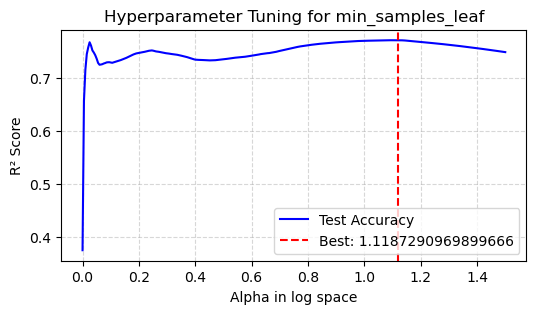

Best estimator: Lasso(alpha=1.1187290969899666)


In [9]:
# Initialize the Lasso model
lasso = Lasso()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.linspace(0, 1.5, 300)  # Fixed logspace range
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 5-fold cross-validation
Lasso_ = GridSearchCV(lasso, param_grid_lasso, cv=cv, scoring='r2')

# Fit the grid search to your training data
Lasso_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Lasso_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Lasso_.best_score_))

# Access the best model
best_model_lasso = Lasso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lasso)
test_MSE = mean_squared_error(ytest, y_pred_lasso)
test_RMSE = root_mean_squared_error(ytest, y_pred_lasso)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 1.5, 300) 
mean_test_scores = Lasso_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(Lasso_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Lasso_.best_params_['alpha']}")
plt.xlabel('Alpha in log space')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for min_samples_leaf')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Lasso_.best_estimator_}')

In [29]:
Lasso_.cv_results_['std_test_score']

array([0.52629004, 0.34048234, 0.29132663, 0.25045042, 0.20807973,
       0.17808578, 0.17741639, 0.18787266, 0.19094351, 0.1966712 ,
       0.20890264, 0.22446685, 0.23403595, 0.23659699, 0.23840643,
       0.23935901, 0.24034382, 0.24047932, 0.24205754, 0.24331732,
       0.24450215, 0.24484991, 0.24376513, 0.24201815, 0.24053327,
       0.23938431, 0.23839039, 0.237363  , 0.23644077, 0.23554888,
       0.23471708, 0.23431108, 0.23397997, 0.23326291, 0.23195326,
       0.23061508, 0.22935668, 0.22810627, 0.22688968, 0.22568875,
       0.22452412, 0.22313255, 0.22150374, 0.22031846, 0.21960548,
       0.21871128, 0.21772796, 0.21693061, 0.21611313, 0.21534185,
       0.21526358, 0.21523074, 0.21522323, 0.21456686, 0.21458762,
       0.21466859, 0.21499781, 0.21519591, 0.21558207, 0.21579074,
       0.21595892, 0.21609542, 0.21623147, 0.2163714 , 0.21655822,
       0.21671031, 0.216944  , 0.21725108, 0.21767447, 0.21787566,
       0.21812343, 0.21841601, 0.21877915, 0.2191683 , 0.21986

In [11]:
meanError = list(Lasso_.cv_results_['mean_test_score'])
stdError = Lasso_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Lasso_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 1.5
One standard error rule gives the best model with mean_test_score: 0.7482159814976684 and std_test_score: 0.16542575196137402


In [12]:
alpha = Lasso_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
lasso = Lasso(alpha=alpha)
lasso.fit(Xtrain, ytrain)
y_pred_lasso = lasso.predict(Xtest)
r2_lasso = r2_score(ytest, y_pred_lasso)
print(f'R² score for Lasso: {r2_lasso:.4f}')

R² score for Lasso: 0.8354


In [13]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lasso,
    'Squared Error (SE)': (ytest - y_pred_lasso) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lasso)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

Mean Squared Error (MSE): 1073.96
Root Mean Squared Error (RMSE): 32.77
Standard Deviation of Actual Values: 82.88


### ElasticNEt REgression

In [14]:
# Initialize the ElasticNet model
elasticNet = ElasticNet()

# Define the hyperparameter grid for ElasticNet
param_grid_en = {
    'alpha': np.linspace(0, 2, 200) ,  # Alpha on a log scale from 0.001 to 1
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 10-fold cross-validation
EN_ = GridSearchCV(elasticNet, param_grid_en, cv=cv, scoring='r2')

# Fit the grid search to your training data
EN_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for ElasticNet found: ", EN_.best_params_)
print("Best cross-validation score for ElasticNet: {:.4f}".format(EN_.best_score_))

# Access the best model
best_model_en = EN_.best_estimator_

# Make predictions on the test set
y_pred_en = best_model_en.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_en)
test_MSE = mean_squared_error(ytest, y_pred_en)
test_RMSE = root_mean_squared_error(ytest, y_pred_en)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Extract the mean_test_score and reshape it to fit the grid of alphas and l1_ratios
mean_test_scores = EN_.cv_results_['mean_test_score'].reshape(len(param_grid_en['l1_ratio']), len(param_grid_en['alpha']))

Best parameters for ElasticNet found:  {'alpha': 1.1155778894472361, 'l1_ratio': 1}
Best cross-validation score for ElasticNet: 0.7706
R² Score on the test dataset: 0.8291
MSE on the test dataset: 1115.1373
RMSE on the test dataset: 33.3937


In [15]:
# Retrieve the cross-validation results for ElasticNet
meanError = list(EN_.cv_results_['mean_test_score'])
stdError = EN_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We check if any models' mean test score is within one standard error of the best model's score
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler model with a higher alpha)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
selected_alpha = EN_.cv_results_['param_alpha'][j]
selected_l1_ratio = EN_.cv_results_['param_l1_ratio'][j]

print(f'One standard error rule selects model with alpha: {selected_alpha} and l1_ratio: {selected_l1_ratio}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 2.0 and l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score: 0.7157683965283098 and std_test_score: 0.19694583539680627


In [16]:
alpha = EN_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
en = ElasticNet(alpha=selected_alpha, l1_ratio=selected_l1_ratio)
en.fit(Xtrain, ytrain)
y_pred_en = en.predict(Xtest)
r2_en = r2_score(ytest, y_pred_en)
print(f'R² score for ElasticNet: {r2_en:.4f}')

R² score for ElasticNet: 0.8349


In [17]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_en,
    'Squared Error (SE)': (ytest - y_pred_en) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_en)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

Mean Squared Error (MSE): 1077.32
Root Mean Squared Error (RMSE): 32.82
Standard Deviation of Actual Values: 82.88


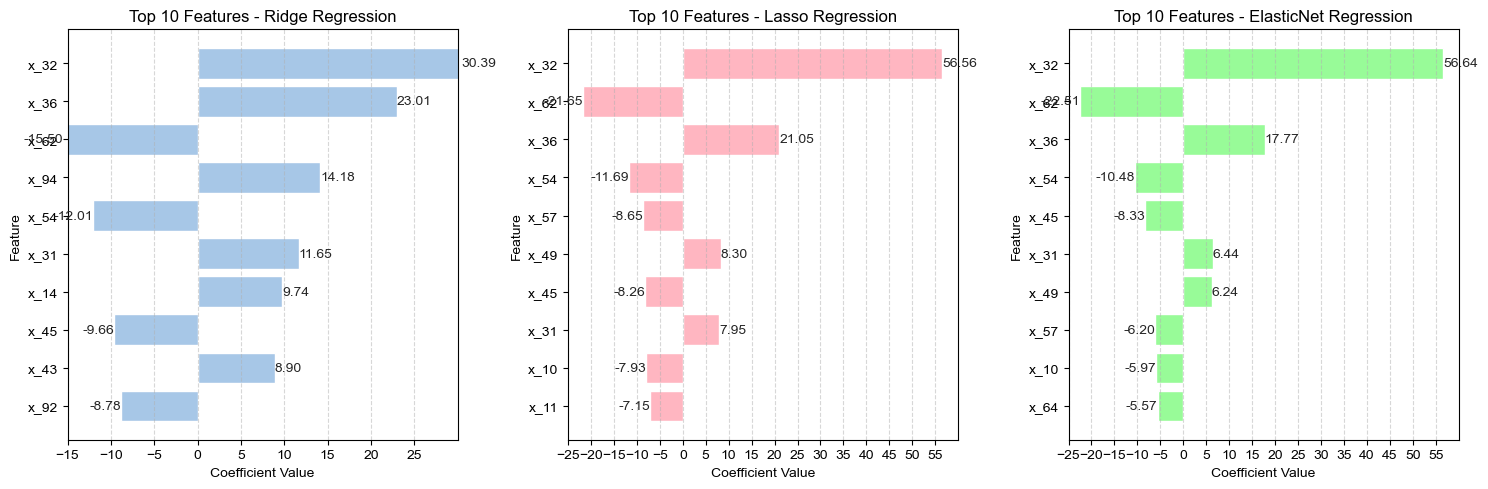

In [18]:
# Feature names (assuming Xtrain is a DataFrame, otherwise use indices)
feature_names = Xtrain.columns

def get_top_features(model):
    """Extract top 10 features based on absolute weight values."""
    coef = model.coef_
    abs_coef = np.abs(coef)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_coef)[-10:]  # Top 10 by absolute magnitude
    
    # Get feature names and corresponding values
    top_features = [feature_names[i] for i in top_indices]
    top_values = coef[top_indices]
    
    return top_features, top_values

# Get top features for each model
ridge_features, ridge_values = get_top_features(ridge)
lasso_features, lasso_values = get_top_features(lasso)
en_features, en_values = get_top_features(en)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use Seaborn style for pastel aesthetics
sns.set_style("whitegrid")

# Define pastel colors
colors = ["#A7C7E7", "#FFB6C1", "#98FB98"]  # Pastel Blue, Pastel Pink, Pastel Green

# Function to plot bars with values on top
def plot_feature_importance(ax, features, values, title, color, xlim_range):
    ax.barh(features, values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim_range[0], xlim_range[1])
    ax.set_xticks(np.arange(xlim_range[0], xlim_range[1], 5))

    # Add value labels
    for i, v in enumerate(values):
        ax.text(v, i, f"{v:.2f}", va='center', ha="left" if v > 0 else "right", fontsize=10)

# Plot Ridge
plot_feature_importance(axes[0], ridge_features, ridge_values, "Top 10 Features - Ridge Regression", colors[0], (-15, 30))

# Plot Lasso
plot_feature_importance(axes[1], lasso_features, lasso_values, "Top 10 Features - Lasso Regression", colors[1], (-25, 60))

# Plot ElasticNet
plot_feature_importance(axes[2], en_features, en_values, "Top 10 Features - ElasticNet Regression", colors[2], (-25, 60))

# Adjust layout
plt.tight_layout()
plt.show()

#### Least angle regression and selection (LARS)

The Least Angle Regression (LARS) method The Lasso strategy in linear regression combines the regularization capabilities of L1 regularization (also called Lasso) with the efficiency of forward selection. Loss of arousal As it moves in the direction of the target variable's greatest correlation, Lasso gradually adds features to the model. This process is continued until a point is reached at which the correlation between the additional variable and the original one would be equal. Due to its tendency to choose a sparse subset of characteristics, this approach works especially well with high-dimensional data. Models with fewer non-zero coefficients are encouraged to be sparse by the regularization term (L1 penalty).

Positive LAsso: Better Stability: Helps avoid issues when highly correlated features lead to coefficients flipping signs.

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Best n_nonzero_coefs: 1.12
Best Cross-Validation R² score: 0.7706
R² Score on the test dataset: 0.8293
MSE on the test dataset: 1114.1166
RMSE on the test dataset: 33.3784


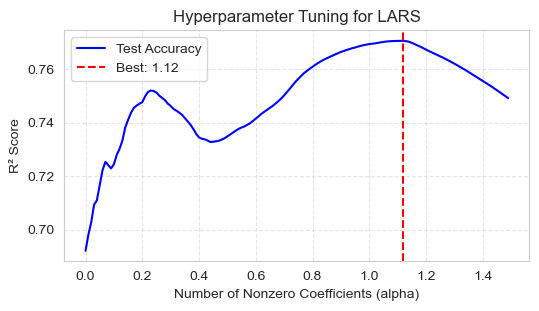

Best estimator: LassoLars(alpha=1.12)


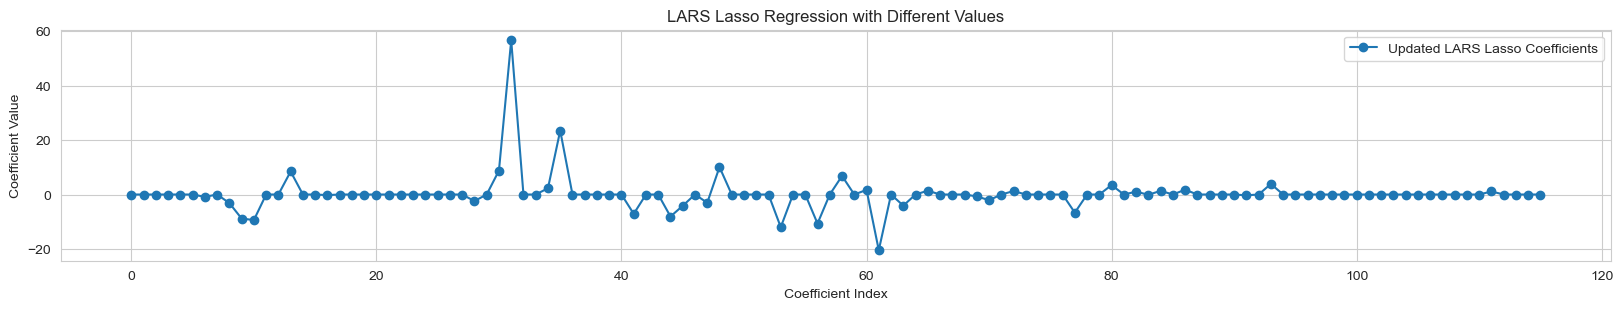

In [19]:
# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "alpha": np.arange(0, 1.5, 0.01)
} 

# Define Lars model
lassolars = LassoLars()

# Use GridSearchCV
LAssoLars_ = GridSearchCV(lassolars, param_grid, scoring="r2", cv=kf, n_jobs=-1, verbose=1)
LAssoLars_.fit(Xtrain, ytrain)

# Get best parameters & results
best_n = LAssoLars_.best_params_["alpha"]
best_mse = LAssoLars_.best_score_

print(f"Best n_nonzero_coefs: {best_n}")
print(f"Best Cross-Validation R² score: {best_mse:.4f}")

# Access the best model
best_model_lars = LAssoLars_.best_estimator_

# Make predictions on the test set
y_pred_lars = best_model_lars.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lars)
test_MSE = mean_squared_error(ytest, y_pred_lars)
test_RMSE = root_mean_squared_error(ytest, y_pred_lars)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.arange(0, 1.5, 0.01)
mean_test_scores = LAssoLars_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(LAssoLars_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {LAssoLars_.best_params_['alpha']}")
plt.xlabel('Number of Nonzero Coefficients (alpha)')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for LARS')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {LAssoLars_.best_estimator_}')

plt.figure(figsize=(20, 3))
plt.plot(best_model_lars.coef_, marker='o', label='Updated LARS Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.title('LARS Lasso Regression with Different Values')
plt.show()

In [20]:
# Retrieve cross-validation results for LARS
meanError = list(LAssoLars_.cv_results_['mean_test_score'])  # Mean R² scores
stdError = LAssoLars_.cv_results_['std_test_score']  # Standard deviation of R² scores

# Find the index of the best-performing model (highest mean test score)
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the most regularized model within the one standard error range
if len(J) > 0:
    j = int(J[-1])  # Choose the most regularized model (simpler with fewer nonzero coefficients)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one
    
# Print results
print(f'One Standard Error Rule selects model with alpha: {LAssoLars_.cv_results_["param_alpha"][j]}')
print(f'Mean R² Score: {meanError[j]:.4f}, Std Error: {stdError[j]:.4f}')

One Standard Error Rule selects model with alpha: 1.49
Mean R² Score: 0.7491, Std Error: 0.1649


In [21]:
param_alpha = LAssoLars_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
lassolars = LassoLars(alpha = param_alpha)
lassolars.fit(Xtrain, ytrain)
y_pred_lassolars = lassolars.predict(Xtest)
r2_lassolars = r2_score(ytest, y_pred_lassolars)
print(f'R² score for LAssoLars: {r2_lassolars:.4f}')

R² score for LAssoLars: 0.8354


In [22]:
# Get non-zero coefficients and corresponding feature indices
non_zero_indices = lassolars.coef_ != 0
non_zero_features = X.columns[non_zero_indices]  # Feature names (if using Pandas)
non_zero_coefs = lassolars.coef_[non_zero_indices]  # Corresponding coefficients

# Print results
print("Selected Features and Coefficients:")
for feature, coef in zip(non_zero_features, non_zero_coefs):
    print(f"{feature}: {coef:.4f}")


Selected Features and Coefficients:
x_07: -1.2570
x_09: -1.6534
x_10: -7.9620
x_11: -7.2020
x_14: 6.5563
x_17: -1.3972
x_29: -2.6837
x_31: 7.9625
x_32: 56.5769
x_35: 2.7195
x_36: 21.1071
x_42: -4.1061
x_45: -8.2592
x_46: -2.5105
x_48: -1.4966
x_49: 8.3450
x_51: -0.5254
x_54: -11.7049
x_57: -8.6952
x_59: 6.1229
x_61: 1.3322
x_62: -21.6292
x_64: -4.6490
x_66: 0.6565
x_68: -0.1300
x_71: -0.4151
x_73: 0.0676
x_78: -5.3364
x_81: 2.3996
x_87: 1.2252
x_94: 3.4652


In [23]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}\n")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

print(df_compare)

Mean Squared Error (MSE): 1074.21
Root Mean Squared Error (RMSE): 32.78
Standard Deviation of Actual Values: 82.88

        Actual   Predicted  Squared Error (SE)  Absolute Error (AE)
83  270.636203  268.486307            4.622056             2.149897
53   58.903739  106.844037         2298.272222            47.940299
70  248.293734  259.006289          114.758855            10.712556
45  134.313059  117.312931          289.004354            17.000128
44  186.770325  199.498367          162.003052            12.728042
39  155.322279  160.290325           24.681481             4.968046
22  235.002343  228.344232           44.330439             6.658111
80  284.455979  280.438910           16.136838             4.017068
10  260.274169  245.069431          231.184041            15.204737
0   375.823073  336.835026         1520.067798            38.988047
18  231.414661  239.634022           67.557897             8.219361
30  194.536800  168.899361          657.278279            25.637439


Lasso and Elastic Net use a coordinate descent method to compute the paths, while Lasso-LARS uses the LARS algorithm to compute the paths.

#### Compare Lasso and Lasso-LARS paths

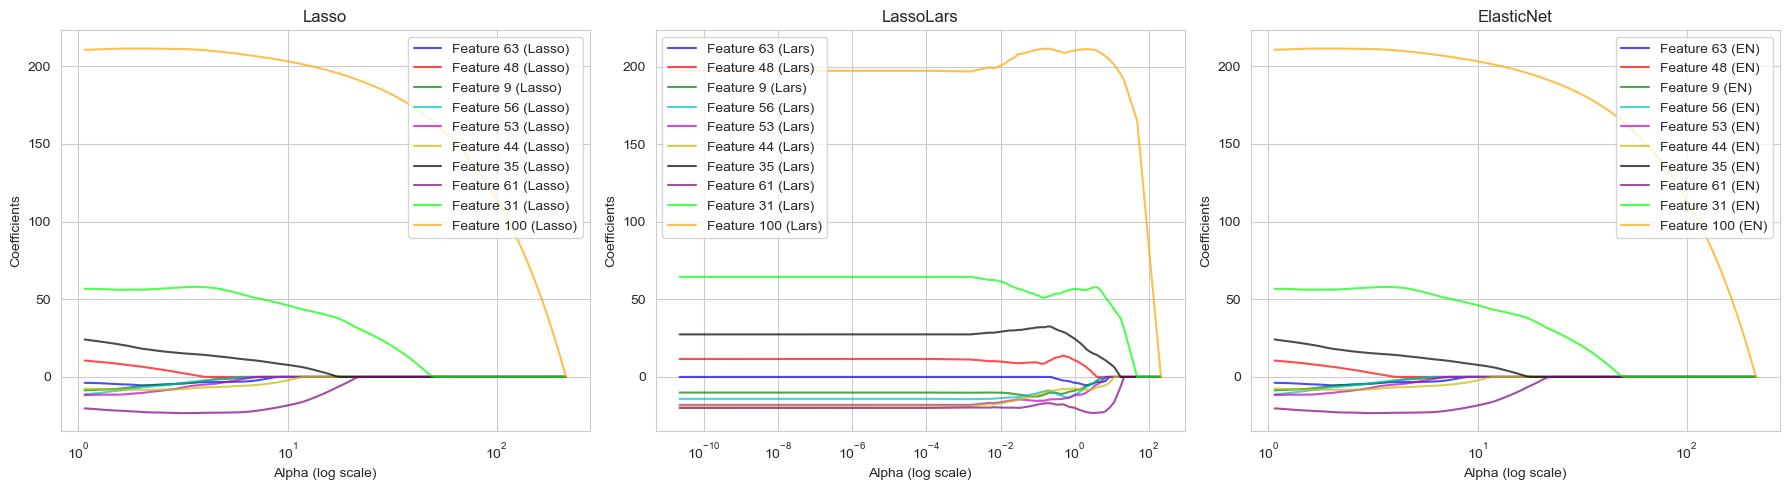

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.linear_model import enet_path, lasso_path, lars_path

# Convert Xtrain and ytrain to NumPy arrays
Xtrain_np = np.ascontiguousarray(Xtrain.to_numpy())  
ytrain_np = np.ascontiguousarray(ytrain.to_numpy())

# Extract best hyperparameters from GridSearchCV
best_alpha_lassolars = LAssoLars_.best_params_['alpha']
best_alpha_lasso = Lasso_.best_params_['alpha']
best_alpha_en = EN_.best_params_['alpha']
best_l1_ratio_en = EN_.best_params_['l1_ratio']

eps = 5e-3  # Controls regularization path resolution

# Compute paths
alphas_lasso, coefs_lasso, _ = lasso_path(Xtrain_np, ytrain_np, eps=eps)
alphas_lars, active, coefs_lars = lars_path(Xtrain_np, ytrain_np, method="lasso")
alphas_enet, coefs_enet, _ = enet_path(Xtrain_np, ytrain_np, eps=eps, l1_ratio=best_l1_ratio_en)

# Identify top 10 most important features based on coefficient magnitudes
importance = np.abs(coefs_lasso).sum(axis=1)  # Sum of absolute values across paths
top_10_idx = np.argsort(importance)[-10:]  # Get indices of top 10 most important features

# Set up plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
colors = cycle(["b", "r", "g", "c", "m", "y", "k", "purple", "lime", "orange"])  # 10 colors

# --- PLOT 1: Lasso vs ElasticNet ---
ax = axes[0]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_lasso, coefs_lasso[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (Lasso)")
ax.set_title("Lasso")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# --- PLOT 2: Lasso vs LassoLars ---
ax = axes[1]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_lars, coefs_lars[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (Lars)")
ax.set_title("LassoLars")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# --- PLOT 3: LassoLars vs ElasticNet ---
ax = axes[2]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_enet, coefs_enet[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (EN)")
ax.set_title("ElasticNet")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

### Polynomial transformation and LAssoLARS regression

In [25]:
# Split X to categorical and continuous variables
continuous = [col for col in X.columns if col.startswith("x_")]
categorical = [col for col in X.columns if col.startswith("C_")]

# Split the data
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly_continuous = poly.fit_transform(X[continuous])
X_poly_continuous_df = pd.DataFrame(X_poly_continuous, columns=poly.get_feature_names_out(continuous), index=X.index)
X_poly = pd.concat([X_poly_continuous_df, X[categorical]], axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, test_size=0.2, random_state=42)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best alpha: 4.149999999999994
Best Cross-Validation R² score: 0.4646
R² Score on the test dataset: 0.6922
MSE on the test dataset: 2008.5223
RMSE on the test dataset: 44.8165


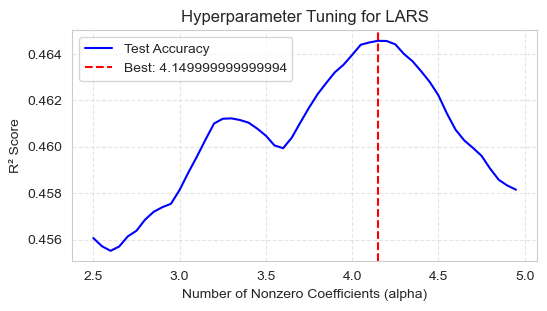

Best estimator: Lasso(alpha=4.149999999999994)


In [26]:
# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "alpha": np.arange(2.5, 5, 0.05)
} 

# Define Lars model
lasso = Lasso()

# Use GridSearchCV
LAsso_ = GridSearchCV(lasso, param_grid, scoring="r2", cv=kf, n_jobs=-1, verbose=1)
LAsso_.fit(Xtrain, ytrain)

# Get best parameters & results
best_alpha = LAsso_.best_params_["alpha"]
best_mse = LAsso_.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best Cross-Validation R² score: {best_mse:.4f}")

# Access the best model
best_model_lars = LAsso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lars.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lasso)
test_MSE = mean_squared_error(ytest, y_pred_lasso)
test_RMSE = root_mean_squared_error(ytest, y_pred_lasso)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.arange(2.5, 5, 0.05)
mean_test_scores = LAsso_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(LAsso_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {LAsso_.best_params_['alpha']}")
plt.xlabel('Number of Nonzero Coefficients (alpha)')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for LARS')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {LAsso_.best_estimator_}')

In [27]:
# Get absolute values of coefficients
coef_abs = np.abs(best_model_lars.coef_)

# Get indices of the highest coefficients (sorted in descending order)
top_indices = np.argsort(coef_abs)[::-1]  # Sort indices by absolute value (largest first)

# Print the top features and their coefficients
top_n = 10  # Adjust this number if you want more/less features
for idx in top_indices[:top_n]:
    print(f"Feature {idx}: Coef {best_model_lars.coef_[idx]}")


Feature 114275: Coef 9.139919208182052
Feature 106335: Coef 7.749307074387533
Feature 56829: Coef 6.283147582305921
Feature 42411: Coef -5.8813091234148684
Feature 131056: Coef -4.526117845425202
Feature 127298: Coef -4.086476076003066
Feature 106524: Coef 3.796205267457034
Feature 107950: Coef 3.6757500652399373
Feature 76031: Coef 3.592496692758604
Feature 112411: Coef -3.45333804033393


In [28]:
# Retrieve cross-validation results for LARS
meanError = list(LAsso_.cv_results_['mean_test_score'])  # Mean R² scores
stdError = LAsso_.cv_results_['std_test_score']  # Standard deviation of R² scores

# Find the index of the best-performing model (highest mean test score)
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the most regularized model within the one standard error range
if len(J) > 0:
    j = int(J[-1])  # Choose the most regularized model (simpler with fewer nonzero coefficients)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one
    
# Print results
print(f'One Standard Error Rule selects model with alpha: {LAsso_.cv_results_["param_alpha"][j]}')
print(f'Mean R² Score: {meanError[j]:.4f}, Std Error: {stdError[j]:.4f}')

One Standard Error Rule selects model with alpha: 4.949999999999991
Mean R² Score: 0.4582, Std Error: 0.2216
